## Projet Python for data Analysis
## AOUES GAYA IBO 1 
## Dataset : Incident management process enriched event log Data Set

Il s'agit du journal d’événements d'un outil de gestion des incidents extrait d'un système d'audit  utilisé par une compagnie IT.
Le dataset fait 141 712 lignes/events pour 36 colonnes/attributs. 
L'objectif est de prédire le temps avant complétion d'un incident. Prédire à quel moment l'incident sera clos par un utilisateur en fonction des attributs du dataset. Une description du dataset avec la liste des attributs expliqués est présente dans le lien du précédent paragraphe. 

## A.1 Import des données

In [1]:
import pandas as pd

In [2]:
dfr=pd.read_csv("incident_event_log.csv", sep=',', encoding='latin-1')

## A.2 afficher avec toutes les colonnes pour checker les données

In [3]:
pd.options.display.max_columns =None

## A.3 decouverte du dataset

In [4]:
dfr.head(1)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00


In [5]:
dfr.shape

(141712, 36)

In [6]:
print(list(dfr.columns))

['number', 'incident_state', 'active', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by', 'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by', 'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at']


## B. Preprocessing
## B.1 Conversion Des dates en Datetime

In [7]:
from datetime import datetime
dfr['closed_at']=dfr.closed_at.astype(str)
dfr['closed_at']= [datetime.strptime(x, '%d/%m/%Y %H:%M') for x in dfr['closed_at']]

dfr['opened_at']=dfr.opened_at.astype(str)
dfr['opened_at']= [datetime.strptime(x, '%d/%m/%Y %H:%M') for x in dfr['opened_at']]

dfr['sys_updated_at']=dfr.sys_updated_at.astype(str)
dfr['sys_updated_at']= [datetime.strptime(x, '%d/%m/%Y %H:%M')for x in dfr['sys_updated_at']]

## Certaines dates sys_created_at sont inconnues
dfr['sys_created_at']=dfr.sys_created_at.astype(str)
dfr['sys_created_at']= [datetime.strptime(x, '%d/%m/%Y %H:%M') if x!= '?' else '?' for x in dfr['sys_created_at'] ]
## Certaines dates resolved_at sont inconnues
dfr['resolved_at']=dfr.resolved_at.astype(str)
dfr['resolved_at']= [datetime.strptime(x, '%d/%m/%Y %H:%M') if x!= '?' else '?' for x in dfr['resolved_at'] ]


## B.2  Calcul des intervalles de temps, de la cible Y

Duree_OpenToClose: Notre target/variable à prédire représente la durée entre le moment où l'incident a été ouvert jusqu'à sa cloture

In [8]:
## Duree open to close
dfr['Duree_openToClose']=dfr['closed_at']-dfr['opened_at']
dfr['Duree_openToClose']=(dfr['Duree_openToClose'].dt.days * 24) + dfr['Duree_openToClose'].dt.seconds / 3600

## B.3 Duree_ResolvedToClose: 
Cette durée correspond à la différence de temps entre la résolution d'un incident et sa cloture

In [9]:
# Duree resolved to close

dfr['Duree_ResolvedToClose']=dfr.apply(lambda row: row["resolved_at"] if row["resolved_at"]== '?' else row['closed_at'] - row['resolved_at']   , axis=1)

# Conversion en string du timedelta
dfr['Duree_ResolvedToClose']=dfr.Duree_ResolvedToClose.astype(str)
# Split du time delta en jours et heures
dfr.loc[dfr['Duree_ResolvedToClose']!='?', 'Duree_ResolvedToCloseTime']= dfr.Duree_ResolvedToClose.str.split(" ", expand=True)[2]
dfr.loc[dfr['Duree_ResolvedToClose']=='?', 'Duree_ResolvedToCloseTime']= '?'
dfr.loc[dfr['Duree_ResolvedToClose']!='?', 'Duree_ResolvedToCloseDays']= dfr.Duree_ResolvedToClose.str.split(" ", expand=True)[0]
dfr.loc[dfr['Duree_ResolvedToClose']=='?', 'Duree_ResolvedToCloseDays']= '?'

# split
dfr['Duree_ResolvedToCloseTime']=dfr.Duree_ResolvedToCloseTime.astype(str)
dfr['Duree_ResolvedToCloseTime']=dfr.apply(lambda row: row["Duree_ResolvedToClose"] if row["Duree_ResolvedToClose"]== '?' else  datetime.strptime(row['Duree_ResolvedToCloseTime'], '%H:%M:%S') , axis=1)

# Resultat resolved to close
dfr['Duree_ResolvedToClose']=dfr.apply(lambda row: row["Duree_ResolvedToClose"] if row["Duree_ResolvedToClose"]== '?' else int(row['Duree_ResolvedToCloseDays'])*24 + row['Duree_ResolvedToCloseTime'].hour + row['Duree_ResolvedToCloseTime'].minute/ 60  , axis=1)

# Suppression des colonnes temporaires
dfr=dfr.drop('Duree_ResolvedToCloseTime',1)
dfr=dfr.drop('Duree_ResolvedToCloseDays',1)



In [10]:
dfr[['number','opened_at','resolved_at','closed_at','Duree_openToClose','Duree_ResolvedToClose']].head(3)

,number,opened_at,resolved_at,closed_at,Duree_openToClose,Duree_ResolvedToClose
0,INC0000045,2016-02-29 01:16:00,2016-02-29 11:29:00,2016-03-05 12:00:00,130.733333,120.517
1,INC0000045,2016-02-29 01:16:00,2016-02-29 11:29:00,2016-03-05 12:00:00,130.733333,120.517
2,INC0000045,2016-02-29 01:16:00,2016-02-29 11:29:00,2016-03-05 12:00:00,130.733333,120.517


## C. Visualisations
## C.1.a Première visualisation: Durée réelle de résolution

Temps de resolution=  (Closed_at - opened_at) - Duree_ResolvedToClose

Le temps entre la résolution et la cloture est parfois consequent. 

Par exemple pour le premier incident= 130 h entre l'ouverture et la cloture mais il y'a 120 h entre le moment où l'incident est deja résolu et sa cloture.

Donc, le temps de résolution entre l'ouverture et la résolution est de seulement 10 h = 130 h - 120 h

In [11]:
## Calcul des temps de résolution.

dfr['Temps_Resolution']=dfr.apply(lambda row: row["Duree_ResolvedToClose"] if row["Duree_ResolvedToClose"]== '?' else row['Duree_openToClose']-row["Duree_ResolvedToClose"]   , axis=1)

## Remplacer les valeurs inconnues de Duree_ResolvedToClose par la moyenne
x=dfr[dfr['Duree_ResolvedToClose']!='?'].Duree_ResolvedToClose.mean()
dfr['Duree_ResolvedToClose']=dfr.apply(lambda row: row["Duree_ResolvedToClose"] if row["Duree_ResolvedToClose"]!= '?' else x, axis=1)

## Remplacer les valeurs inconnues de Temps_Resolution par la moyenne
x=dfr[dfr['Temps_Resolution']!='?'].Temps_Resolution.mean()
dfr['Temps_Resolution']=dfr.apply(lambda row: row["Temps_Resolution"] if row["Temps_Resolution"]!= '?' else x, axis=1)

In [12]:
dfr[['number','Duree_openToClose','Duree_ResolvedToClose','Temps_Resolution']].head(3)

,number,Duree_openToClose,Duree_ResolvedToClose,Temps_Resolution
0,INC0000045,130.733333,120.516667,10.216667
1,INC0000045,130.733333,120.516667,10.216667
2,INC0000045,130.733333,120.516667,10.216667


## C.1.b Première visualisation: Graphe de la répartition du temps de résolution par rapport a temps total

In [19]:
## Graph de la répartition
dfRepartitionTemps=dfr.copy()

## On groupe by sur le number, pour prendre en compte une seule fois chaque incident 
dfRepartitionTemps=dfRepartitionTemps.groupby('number').mean()

resolution=dfRepartitionTemps['Temps_Resolution'].mean()
cloture=dfRepartitionTemps['Duree_ResolvedToClose'].mean()

datas = {'Tempsresolution': [resolution], 'TempsDeCloture': [cloture]}
dfRepartition = pd.DataFrame(data=datas)

Text(0, 0.5, 'Temps en heure')

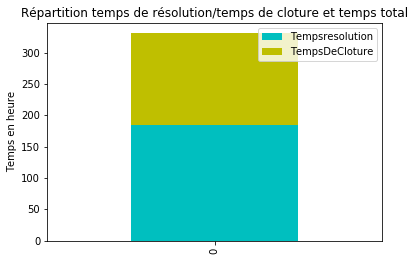

In [20]:
import matplotlib.pyplot as plt
my_colors = 'cy'

dfRepartition.plot(kind='bar',stacked=True, color=my_colors)

#Set descriptions:
plt.title("Répartition temps de résolution/temps de cloture et temps total")
plt.ylabel('Temps en heure')

In [21]:
dfRepartition

,Tempsresolution,TempsDeCloture
0,183.88058,147.074101


Au total: 330 h en moyenne pour un incident pour la durée Open to close
réparties de cette façon: 183 h en moyenne de temps de résolution et 147 h de temps de cloture

## C.2 Deuxième visualisation:  Durée Open to Close en fonction da la priorité de l'incident

In [22]:
## Valeurs possibles pour la priorité
dfr['priority'].value_counts(dropna=False)

3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Critical      2258
Name: priority, dtype: int64

In [23]:
df_visu2=dfr[['number','priority','Duree_openToClose']].copy()

## On aggrége d'abord par incident pour pas avoir une moyenne fiable pour les incidents
df_visu2=df_visu2.groupby('number').agg({'priority':'last','Duree_openToClose':'mean'})
## On groupe by priority
df_visu2=df_visu2.groupby('priority').mean()


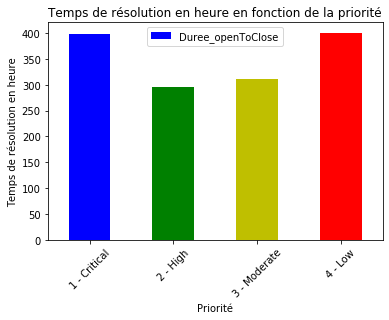

In [24]:
import matplotlib.pyplot as plt
my_colors = 'bgyr'
df_visu2.plot(kind='bar', color=my_colors)

#Set descriptions:
plt.title("Temps de résolution en heure en fonction de la priorité")
plt.ylabel('Temps de résolution en heure')
plt.xlabel('Priorité')

plt.xticks(rotation=45)

ax = plt.gca()
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

De low jusqu'a high, plus la priorité augmente plus l'incident est résolut rapidement
Pour critical, c'est pour les gros problèmes qui nécessitent beaucoup de temps a etre résolus.



## C. 3 Troisième visualisation: Matrice de corrélation avec les colonnes numériques

Dans un premier on aggrège par le number de l'incident en retenant le max de reassignment_count, reopen_count, sys_mod_count, made_sla, u_priority_confirmation.


In [29]:
dfvisu3=dfr[['number','reassignment_count','reopen_count','sys_mod_count','made_sla','u_priority_confirmation','Duree_openToClose']].copy()

dfvisu3=dfvisu3.groupby('number').agg({'reassignment_count':'max',
                                           'reopen_count':'max',
                                           'sys_mod_count':'max',
                                           'made_sla':'max',
                                           'u_priority_confirmation':'max',
                                           'Duree_openToClose': 'max'})

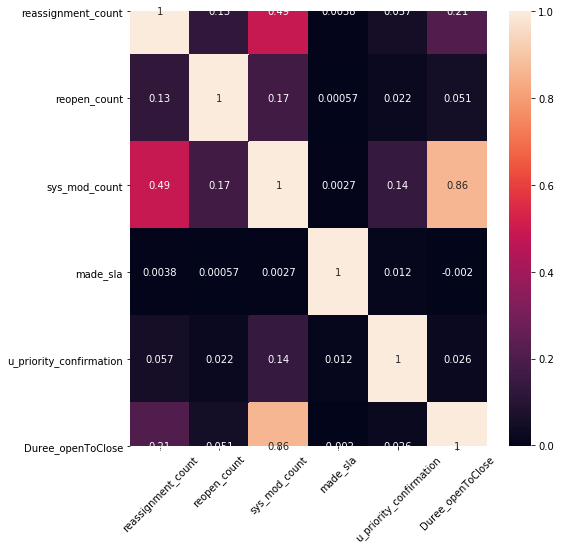

In [30]:
corrMatrix = dfvisu3.corr()

## On utilise searborn pour la heatmap
import seaborn as sn

plt.subplots(figsize=(8,8))
heat_map=sn.heatmap(corrMatrix, annot=True)

heat_map.set_xticklabels(heat_map.get_yticklabels(), rotation=45)

plt.show()

On voit bien que la variable qui est corrélée à Duree_openToClose est sys_mod_count. 
Quand on a aggrégé par number, on a retenu le max pour cette variable, qui correspond au nombre total de modifications subies par l'incident.

Plus l'incident a été modifié plus il prend du temps à etre résolu.

## D. Modèles

## D.1 Premier modèle simple sans aggréger sur number (id de l'incident): score faible, pas encore optimisé

In [33]:
### On prend que les variables numériques dans un premier temps
dfrNormal=dfr[['Duree_openToClose','active','made_sla','u_priority_confirmation','knowledge','sys_mod_count','reassignment_count','reopen_count']].copy()



## One hot encoing des variables catégoriques pour le dataset sans aggregation sur number

In [34]:
## On encode les variables catégoriques: dummification

dfP=dfr['priority'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["priority"], prefix='priority' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['closed_code'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["closed_code"], prefix='closed_code' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['category'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["category"], prefix='category' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['assignment_group'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["assignment_group"], prefix='assignment_group' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['opened_by'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["opened_by"], prefix='opened_by' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['contact_type'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["contact_type"], prefix='contact_type' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['impact'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["impact"], prefix='impact' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['urgency'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["urgency"], prefix='urgency' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['caused_by'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["caused_by"], prefix='caused_by' )
dfrNormal=dfrNormal.join(dum_dfp)

dfP=dfr['vendor'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["rfc"], prefix='rfc' )
dfrNormal=dfrNormal.join(dum_dfp)

In [36]:
dfrNormal.head(3)

,Duree_openToClose,active,made_sla,u_priority_confirmation,knowledge,sys_mod_count,reassignment_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low,closed_code_?,closed_code_code 1,closed_code_code 10,closed_code_code 11,closed_code_code 12,closed_code_code 13,closed_code_code 14,closed_code_code 15,closed_code_code 16,closed_code_code 17,closed_code_code 2,closed_code_code 3,closed_code_code 4,closed_code_code 5,closed_code_code 6,closed_code_code 7,closed_code_code 8,closed_code_code 9,category_?,category_Category 10,category_Category 12,category_Category 13,category_Category 14,category_Category 15,category_Category 16,category_Category 17,category_Category 19,category_Category 2,category_Category 20,category_Category 21,category_Category 22,category_Category 23,category_Category 24,category_Category 25,category_Category 26,category_Category 27,category_Category 28,category_Category 29,category_Category 3,category_Category 30,category_Category 31,category_Category 32,category_Category 33,category_Category 34,category_Category 35,category_Category 36,category_Category 37,category_Category 38,category_Category 4,category_Category 40,category_Category 41,category_Category 42,category_Category 43,category_Category 44,category_Category 45,category_Category 46,category_Category 47,category_Category 48,category_Category 49,category_Category 5,category_Category 50,category_Category 51,category_Category 52,category_Category 53,category_Category 54,category_Category 55,category_Category 56,category_Category 57,category_Category 58,category_Category 59,category_Category 6,category_Category 61,category_Category 62,category_Category 63,category_Category 7,category_Category 8,category_Category 9,assignment_group_?,assignment_group_Group 10,assignment_group_Group 11,assignment_group_Group 12,assignment_group_Group 13,assignment_group_Group 14,assignment_group_Group 15,assignment_group_Group 16,assignment_group_Group 17,assignment_group_Group 18,assignment_group_Group 19,assignment_group_Group 2,assignment_group_Group 20,assignment_group_Group 21,assignment_group_Group 22,assignment_group_Group 23,assignment_group_Group 24,assignment_group_Group 25,assignment_group_Group 26,assignment_group_Group 27,assignment_group_Group 28,assignment_group_Group 29,assignment_group_Group 3,assignment_group_Group 30,assignment_group_Group 31,assignment_group_Group 32,assignment_group_Group 33,assignment_group_Group 34,assignment_group_Group 35,assignment_group_Group 36,assignment_group_Group 37,assignment_group_Group 38,assignment_group_Group 39,assignment_group_Group 4,assignment_group_Group 41,assignment_group_Group 43,assignment_group_Group 44,assignment_group_Group 45,assignment_group_Group 46,assignment_group_Group 47,assignment_group_Group 48,assignment_group_Group 49,assignment_group_Group 5,assignment_group_Group 50,assignment_group_Group 51,assignment_group_Group 53,assignment_group_Group 54,assignment_group_Group 55,assignment_group_Group 56,assignment_group_Group 57,assignment_group_Group 58,assignment_group_Group 59,assignment_group_Group 6,assignment_group_Group 60,assignment_group_Group 61,assignment_group_Group 62,assignment_group_Group 63,assignment_group_Group 64,assignment_group_Group 65,assignment_group_Group 66,assignment_group_Group 67,assignment_group_Group 68,assignment_group_Group 69,assignment_group_Group 7,assignment_group_Group 70,assignment_group_Group 71,assignment_group_Group 72,assignment_group_Group 73,assignment_group_Group 74,assignment_group_Group 75,assignment_group_Group 76,assignment_group_Group 77,assignment_group_Group 78,assignment_group_Group 79,assignment_group_Group 8,assignment_group_Group 80,assignment_group_Group 81,assignment_group_Group 82,assignment_group_Group 9,opened_by_?,opened_by_Opened by 10,opened_by_Opened by 101,opened_by_Opened by 104,opened_by_Opened by 106,opened_by_Opened by 108,opened_by_Opened by 109,opened_by_Opened by 111,opened_by_Opened by 11

## Split du dataset en train et test set pour le dataset sans aggregation

In [37]:

dfinal=dfrNormal.copy()

y=dfinal.Duree_openToClose
x=dfinal.drop('Duree_openToClose',axis=1)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1234)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((106284, 395), (35428, 395), (106284,), (35428,))

## Regression lineaire pour le dataset sans aggregation

In [38]:
performances =dict()

from sklearn.linear_model import LinearRegression
algorithme = LinearRegression()
algorithme.fit(x_train,y_train)
score=algorithme.score(x_test, y_test)
score

0.5706512094880525

In [39]:
performances['df_Normal_LinearRegression']=score

##  Decision tree regressor pour le dataset sans aggregation

In [40]:
from sklearn.tree import DecisionTreeRegressor
algorithme = DecisionTreeRegressor()
algorithme.fit(x_train, y_train)
score=algorithme.score(x_test,y_test)
score

0.5929514683655271

In [41]:
performances['df_Normal_DecisionTreeRegressor']=score

## 4.2 Modele avec Groupe By incident number 
## a. Regression linéaire

On groupe by sur le number (identifiant des incident)

On retient le max de: Duree_openToClose, reassignment_count, reopen_count, sys_mod_count, made_sla, u_priority_confirmation, knowledge
On retient le dernier: priority, closed_code, category, vendor, impact, urgency, caused_by, contact_type

In [71]:
dfGrouped=dfr.copy()
dfGrouped=dfGrouped.groupby('number').agg({'reassignment_count':'max',
                                           'reopen_count':'max',
                                           'sys_mod_count':'max',
                                           'made_sla':'max',
                                           'u_priority_confirmation':'max',
                                           'knowledge':'max',
                                           'priority': 'last',
                                           'closed_code':'last',
                                           'category':'last',
                                           'vendor':'last',
                                           'impact':'last',
                                           'urgency':'last',
                                           'caused_by':'last',
                                           'contact_type':'last',
                                           'Duree_openToClose': 'max'})


## Modele sans dummies

In [98]:
dfGrouped2=dfr.copy()
dfGrouped2=dfGrouped2.groupby('number').agg({'reassignment_count':'max',
                                           'reopen_count':'max',
                                           'sys_mod_count':'max',
                                           'made_sla':'max',
                                           'u_priority_confirmation':'max',
                                           'knowledge':'max',
                                           'Duree_openToClose': 'max'})

In [99]:
dfinal2=dfGrouped2.copy()
y=dfinal2.Duree_openToClose
x=dfinal2.drop('Duree_openToClose',axis=1)

In [100]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1234)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((18688, 6), (6230, 6), (18688,), (6230,))

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(x_test)

In [101]:
from sklearn.linear_model import LinearRegression
algorithme = LinearRegression()
algorithme.fit(x_train,y_train)
score=algorithme.score(x_test, y_test)
score


0.8645309884747335

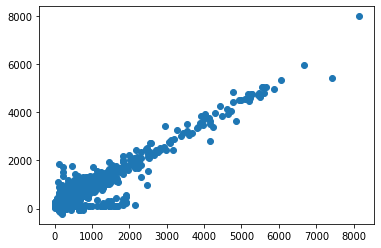

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x=y_test, y=algorithme.predict(x_test))

## DUMP

In [105]:
from sklearn.externals import joblib


C:\Users\baya\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [106]:
joblib.dump(algorithme, "model_simple.sav")

['model_simple.sav']

In [107]:
joblib.dump(scaler, "scaler.sav")

['scaler.sav']

In [108]:
!ls

Incidents_Dataset_Simple_Prediction.ipynb
catboost_info
incident_event_log.csv
model_simple.sav
scaler.sav


## Test Load

In [109]:
scaler2 = joblib.load("scaler.sav")
X = scaler2.transform(X)



In [110]:
lm2 = joblib.load("model_simple.sav")

In [114]:
lm2.predict(X)


array([1421.97423232,  745.33373191, 1422.85490429, ...,  812.73498258,
        778.15368528, 1708.01400533])

## One hot encoing pour le dataset grouped by number pour les variables catégoriques

In [91]:
dfP=dfGrouped['priority'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["priority"], prefix='priority' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['closed_code'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["closed_code"], prefix='closed_code' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['category'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["category"], prefix='category' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['vendor'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["vendor"], prefix='vendor' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['impact'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["impact"], prefix='impact' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['urgency'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["urgency"], prefix='urgency' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['caused_by'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["caused_by"], prefix='caused_by' )
dfGrouped=dfGrouped.join(dum_dfp)

dfP=dfGrouped['contact_type'].copy()
dum_dfp = pd.get_dummies(dfP, columns=["contact_type"], prefix='contact_type' )
dfGrouped=dfGrouped.join(dum_dfp)

dfGrouped=dfGrouped.drop(['priority','closed_code','category','vendor','impact','urgency','caused_by','contact_type','contact_type'],1)

In [92]:
dfGrouped.head(3)

,reassignment_count,reopen_count,sys_mod_count,made_sla,u_priority_confirmation,knowledge,Duree_openToClose,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low,closed_code_?,closed_code_code 1,closed_code_code 10,closed_code_code 11,closed_code_code 12,closed_code_code 13,closed_code_code 14,closed_code_code 15,closed_code_code 16,closed_code_code 17,closed_code_code 2,closed_code_code 3,closed_code_code 4,closed_code_code 5,closed_code_code 6,closed_code_code 7,closed_code_code 8,closed_code_code 9,category_?,category_Category 10,category_Category 12,category_Category 13,category_Category 14,category_Category 16,category_Category 17,category_Category 19,category_Category 2,category_Category 20,category_Category 21,category_Category 22,category_Category 23,category_Category 24,category_Category 25,category_Category 26,category_Category 28,category_Category 29,category_Category 30,category_Category 31,category_Category 32,category_Category 33,category_Category 34,category_Category 35,category_Category 37,category_Category 38,category_Category 4,category_Category 40,category_Category 42,category_Category 43,category_Category 44,category_Category 45,category_Category 46,category_Category 47,category_Category 48,category_Category 5,category_Category 50,category_Category 51,category_Category 52,category_Category 53,category_Category 54,category_Category 55,category_Category 56,category_Category 57,category_Category 58,category_Category 59,category_Category 6,category_Category 61,category_Category 62,category_Category 63,category_Category 7,category_Category 8,category_Category 9,vendor_?,vendor_Vendor 1,vendor_code 8s,impact_1 - High,impact_2 - Medium,impact_3 - Low,urgency_1 - High,urgency_2 - Medium,urgency_3 - Low,caused_by_?,caused_by_CHG0000097,caused_by_CHG0000132,caused_by_CHG0001327,contact_type_Direct opening,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service
number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,0,0,4,True,False,True,130.733333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
INC0000047,1,0,8,True,False,True,149.333333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
INC0000057,0,0,6,True,False,True,140.833333,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0


## Split en train set et test set pour le dataset Grouped by

In [93]:
dfinal=dfGrouped.copy()
y=dfinal.Duree_openToClose
x=dfinal.drop('Duree_openToClose',axis=1)

In [94]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1234)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((18688, 99), (6230, 99), (18688,), (6230,))

## Regression lineaire simple pour le dataset Grouped by number

In [95]:
from sklearn.linear_model import LinearRegression
algorithme = LinearRegression()
algorithme.fit(x_train,y_train)
score=algorithme.score(x_test, y_test)
score

0.8697542020846498

In [96]:
performances['df_grouped_LinearRegression']=score

## b. Decision tree regressor  pour le dataset Grouped by number


In [51]:
from sklearn.tree import DecisionTreeRegressor
algorithme = DecisionTreeRegressor()
algorithme.fit(x_train, y_train)
score=algorithme.score(x_test,y_test)
score

0.7689735292788941

In [52]:
performances['df_grouped_DecisionTreeRegressor']=score

## c. Random Forest  pour le dataset Grouped by number


In [54]:
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':30 }
algorithme = RandomForestRegressor(**hyperparametres)
algorithme.fit(x_train,y_train)
score=algorithme.score(x_test,y_test)
score

0.8707010444085542

In [55]:
performances['df_grouped_RandomForest']=score

## d. Catboost pour le dataset Grouped by number

In [57]:
from catboost import CatBoostRegressor
algorithme = CatBoostRegressor(task_type="CPU")
algorithme.fit(x_train, y_train)
score=algorithme.score(x_test,y_test)
score


0:	learn: 526.5427800	total: 602ms	remaining: 10m 1s
1:	learn: 515.3886739	total: 609ms	remaining: 5m 4s
2:	learn: 504.6644148	total: 752ms	remaining: 4m 9s
3:	learn: 494.2101603	total: 796ms	remaining: 3m 18s
4:	learn: 484.3889583	total: 948ms	remaining: 3m 8s
5:	learn: 474.6001420	total: 1.13s	remaining: 3m 7s
6:	learn: 465.3817052	total: 1.15s	remaining: 2m 42s
7:	learn: 456.4740041	total: 1.19s	remaining: 2m 27s
8:	learn: 447.2901731	total: 1.22s	remaining: 2m 14s
9:	learn: 439.3635690	total: 1.29s	remaining: 2m 8s
10:	learn: 431.5795386	total: 1.3s	remaining: 1m 56s
11:	learn: 423.5139547	total: 1.31s	remaining: 1m 48s
12:	learn: 415.5416062	total: 1.44s	remaining: 1m 49s
13:	learn: 408.0253985	total: 1.45s	remaining: 1m 42s
14:	learn: 400.9110659	total: 1.46s	remaining: 1m 35s
15:	learn: 393.8397473	total: 1.46s	remaining: 1m 29s
16:	learn: 386.8450831	total: 1.5s	remaining: 1m 26s
17:	learn: 380.4263195	total: 1.55s	remaining: 1m 24s
18:	learn: 374.3203111	total: 1.56s	remaining

167:	learn: 206.3726201	total: 3.96s	remaining: 19.6s
168:	learn: 206.3205866	total: 3.98s	remaining: 19.6s
169:	learn: 206.2414230	total: 4s	remaining: 19.5s
170:	learn: 206.1593101	total: 4.01s	remaining: 19.4s
171:	learn: 206.1054082	total: 4.01s	remaining: 19.3s
172:	learn: 206.0115438	total: 4.02s	remaining: 19.2s
173:	learn: 205.9652331	total: 4.03s	remaining: 19.1s
174:	learn: 205.8741427	total: 4.04s	remaining: 19s
175:	learn: 205.7835961	total: 4.05s	remaining: 19s
176:	learn: 205.7169837	total: 4.08s	remaining: 18.9s
177:	learn: 205.6335331	total: 4.08s	remaining: 18.8s
178:	learn: 205.5922151	total: 4.09s	remaining: 18.7s
179:	learn: 205.5460711	total: 4.09s	remaining: 18.7s
180:	learn: 205.4349508	total: 4.11s	remaining: 18.6s
181:	learn: 205.3340987	total: 4.12s	remaining: 18.5s
182:	learn: 205.2618695	total: 4.13s	remaining: 18.4s
183:	learn: 205.2232977	total: 4.16s	remaining: 18.4s
184:	learn: 205.1572833	total: 4.19s	remaining: 18.5s
185:	learn: 205.1133744	total: 4.24

331:	learn: 196.7014333	total: 6.63s	remaining: 13.3s
332:	learn: 196.6709580	total: 6.71s	remaining: 13.4s
333:	learn: 196.5961901	total: 6.72s	remaining: 13.4s
334:	learn: 196.5244524	total: 6.76s	remaining: 13.4s
335:	learn: 196.4979557	total: 6.82s	remaining: 13.5s
336:	learn: 196.4700473	total: 6.83s	remaining: 13.4s
337:	learn: 196.4287446	total: 6.84s	remaining: 13.4s
338:	learn: 196.4048918	total: 6.85s	remaining: 13.4s
339:	learn: 196.3729172	total: 6.86s	remaining: 13.3s
340:	learn: 196.3366601	total: 6.88s	remaining: 13.3s
341:	learn: 196.3011276	total: 6.89s	remaining: 13.3s
342:	learn: 196.2297328	total: 6.91s	remaining: 13.2s
343:	learn: 196.1868116	total: 6.92s	remaining: 13.2s
344:	learn: 196.1154006	total: 6.93s	remaining: 13.2s
345:	learn: 196.0985899	total: 6.93s	remaining: 13.1s
346:	learn: 196.0713692	total: 6.95s	remaining: 13.1s
347:	learn: 196.0175879	total: 6.95s	remaining: 13s
348:	learn: 195.9653068	total: 6.96s	remaining: 13s
349:	learn: 195.9261775	total: 6

484:	learn: 191.2357181	total: 8.65s	remaining: 9.19s
485:	learn: 191.2006861	total: 8.66s	remaining: 9.16s
486:	learn: 191.1590844	total: 8.68s	remaining: 9.14s
487:	learn: 191.1016228	total: 8.69s	remaining: 9.11s
488:	learn: 191.0791262	total: 8.7s	remaining: 9.09s
489:	learn: 191.0450957	total: 8.73s	remaining: 9.09s
490:	learn: 190.9924820	total: 8.75s	remaining: 9.07s
491:	learn: 190.9473591	total: 8.75s	remaining: 9.04s
492:	learn: 190.9315008	total: 8.76s	remaining: 9.01s
493:	learn: 190.8749903	total: 8.76s	remaining: 8.98s
494:	learn: 190.8568528	total: 8.8s	remaining: 8.98s
495:	learn: 190.8013213	total: 8.81s	remaining: 8.95s
496:	learn: 190.7823670	total: 8.81s	remaining: 8.92s
497:	learn: 190.7544839	total: 8.82s	remaining: 8.89s
498:	learn: 190.6999281	total: 8.83s	remaining: 8.87s
499:	learn: 190.6744068	total: 8.85s	remaining: 8.85s
500:	learn: 190.6208494	total: 8.87s	remaining: 8.83s
501:	learn: 190.5865510	total: 8.87s	remaining: 8.8s
502:	learn: 190.5529110	total: 

637:	learn: 186.4592358	total: 11.4s	remaining: 6.45s
638:	learn: 186.4393293	total: 11.4s	remaining: 6.43s
639:	learn: 186.4282001	total: 11.4s	remaining: 6.4s
640:	learn: 186.4056883	total: 11.4s	remaining: 6.4s
641:	learn: 186.3690143	total: 11.4s	remaining: 6.38s
642:	learn: 186.3327630	total: 11.4s	remaining: 6.36s
643:	learn: 186.3233353	total: 11.5s	remaining: 6.33s
644:	learn: 186.2825611	total: 11.5s	remaining: 6.31s
645:	learn: 186.2446508	total: 11.5s	remaining: 6.28s
646:	learn: 186.2188527	total: 11.5s	remaining: 6.28s
647:	learn: 186.1933642	total: 11.5s	remaining: 6.26s
648:	learn: 186.1573440	total: 11.6s	remaining: 6.26s
649:	learn: 186.1341250	total: 11.6s	remaining: 6.24s
650:	learn: 186.1248793	total: 11.7s	remaining: 6.26s
651:	learn: 186.1041232	total: 11.7s	remaining: 6.24s
652:	learn: 186.0769076	total: 11.7s	remaining: 6.21s
653:	learn: 186.0678136	total: 11.8s	remaining: 6.22s
654:	learn: 186.0488943	total: 11.8s	remaining: 6.22s
655:	learn: 186.0115334	total:

795:	learn: 183.1314356	total: 14.2s	remaining: 3.63s
796:	learn: 183.1114573	total: 14.2s	remaining: 3.61s
797:	learn: 183.0835993	total: 14.2s	remaining: 3.59s
798:	learn: 183.0561653	total: 14.2s	remaining: 3.57s
799:	learn: 183.0426364	total: 14.2s	remaining: 3.54s
800:	learn: 183.0222727	total: 14.2s	remaining: 3.52s
801:	learn: 183.0068375	total: 14.2s	remaining: 3.5s
802:	learn: 182.9767594	total: 14.2s	remaining: 3.48s
803:	learn: 182.9501368	total: 14.2s	remaining: 3.46s
804:	learn: 182.9239184	total: 14.2s	remaining: 3.44s
805:	learn: 182.9140055	total: 14.2s	remaining: 3.42s
806:	learn: 182.9010568	total: 14.2s	remaining: 3.4s
807:	learn: 182.8876335	total: 14.2s	remaining: 3.38s
808:	learn: 182.8683114	total: 14.2s	remaining: 3.36s
809:	learn: 182.8424812	total: 14.3s	remaining: 3.35s
810:	learn: 182.8317583	total: 14.3s	remaining: 3.33s
811:	learn: 182.8078186	total: 14.3s	remaining: 3.31s
812:	learn: 182.7952956	total: 14.3s	remaining: 3.29s
813:	learn: 182.7931379	total:

949:	learn: 180.6313887	total: 16.5s	remaining: 871ms
950:	learn: 180.6109960	total: 16.6s	remaining: 853ms
951:	learn: 180.5992000	total: 16.6s	remaining: 835ms
952:	learn: 180.5900883	total: 16.6s	remaining: 817ms
953:	learn: 180.5819397	total: 16.6s	remaining: 799ms
954:	learn: 180.5618533	total: 16.6s	remaining: 783ms
955:	learn: 180.5532676	total: 16.6s	remaining: 766ms
956:	learn: 180.5427824	total: 16.6s	remaining: 748ms
957:	learn: 180.5316009	total: 16.6s	remaining: 730ms
958:	learn: 180.5238370	total: 16.7s	remaining: 712ms
959:	learn: 180.5040487	total: 16.7s	remaining: 694ms
960:	learn: 180.4954491	total: 16.7s	remaining: 677ms
961:	learn: 180.4667312	total: 16.7s	remaining: 659ms
962:	learn: 180.4641341	total: 16.7s	remaining: 641ms
963:	learn: 180.4597200	total: 16.7s	remaining: 623ms
964:	learn: 180.4479086	total: 16.7s	remaining: 606ms
965:	learn: 180.4287857	total: 16.7s	remaining: 589ms
966:	learn: 180.4229701	total: 16.7s	remaining: 571ms
967:	learn: 180.4146695	tota

0.9064716896673904

In [58]:
performances['df_grouped_Catboost']=score

## e. ExtratreesRegressor pour le dataset Grouped by number

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

algorithme = ExtraTreesRegressor()
algorithme.fit(x_train, y_train)
score=algorithme.score(x_test,y_test)
score

C:\Users\baya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8340799873297016

In [60]:
performances['df_grouped_ExtraTreesRegressor']=score


## f. GradientBoosting pour le dataset Grouped by number

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
algorithme = GradientBoostingRegressor()
algorithme.fit(x_train, y_train)
score=algorithme.score(x_test,y_test)
score

0.9078226122451317

In [62]:
performances['df_grouped_GradientBoosting']=score

## E.  GridSearch: trouver les meilleurs parametres

In [63]:
from sklearn.model_selection import GridSearchCV

estimator=RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
     

In [64]:
grid.best_score_

0.8333717794461287

In [65]:
grid.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 8,
 'n_estimators': 30}

## On peut alors les utiliser



In [66]:
algorithme=RandomForestRegressor(bootstrap=True,max_features='auto',min_samples_split=8, n_estimators=30)

algorithme.fit(x_train,y_train)
score=algorithme.score(x_test,y_test)
score

0.8993497379166027

ON voit une amélioration en passant de 0,85 à 0,90

In [68]:
performances['df_grouped_RandomForestWithCV']=score

## F. Visualisation des performances des différents algos

In [69]:
from collections import OrderedDict
dico = OrderedDict(performances)

import pandas as pd
df = pd.DataFrame()
df["perf"] = dico.values()
df["algo"] = dico.keys()
df['nom_algo'] = df.algo.apply(lambda algo: str(algo).split('(')[0])
df.set_index('nom_algo', inplace=True)
df

,perf,algo
nom_algo,,
df_Normal_LinearRegression,0.570651,df_Normal_LinearRegression
df_Normal_DecisionTreeRegressor,0.592951,df_Normal_DecisionTreeRegressor
df_grouped_LinearRegression,0.869754,df_grouped_LinearRegression
df_grouped_DecisionTreeRegressor,0.768974,df_grouped_DecisionTreeRegressor
df_grouped_RandomForest,0.870701,df_grouped_RandomForest
df_grouped_Catboost,0.906472,df_grouped_Catboost
df_grouped_ExtraTreesRegressor,0.834080,df_grouped_ExtraTreesRegressor
df_grouped_GradientBoosting,0.907823,df_grouped_GradientBoosting
df_grouped_RandomForestWithCV,0.899350,df_grouped_RandomForestWithCV


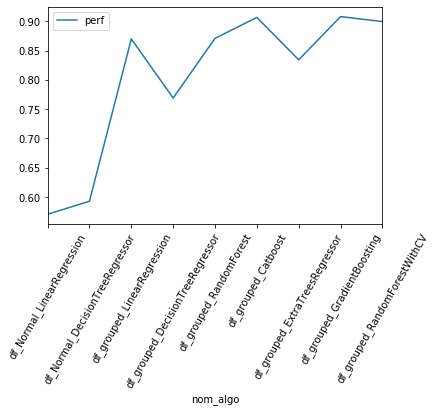

In [70]:
df[["perf"]].plot(kind='line', rot=60)
